# Preparação

In [ ]:
!pip install python-igraph
!pip install powerlaw
!git clone https://github.com/vgarciasc/automatic-dating-cn

     |████████████████████████████████| 3.2MB 7.6MB/s 
  Created wheel for powerlaw: filename=powerlaw-1.4.6-cp36-none-any.whl size=24788 sha256=3960397bc0283c9bc46ba0e3133c2628b848e733946bf7e8487891f138e37bc4
  Stored in directory: /root/.cache/pip/wheels/e0/27/02/08d0e2865072bfd8d7c655e290521e3feca3fc22f1ac460601
Successfully built powerlaw
Cloning into 'automatic-dating-cn'...
remote: Enumerating objects: 339, done.
remote: Counting objects: 100% (339/339), done.
remote: Compressing objects: 100% (213/213), done.
remote: Total 339 (delta 150), reused 310 (delta 124), pack-reused 0
Receiving objects: 100% (339/339), 39.41 MiB | 19.95 MiB/s, done.
Resolving deltas: 100% (150/150), done.
Checking out files: 100% (257/257), done.


In [ ]:
%cd automatic-dating-cn

/content/automatic-dating-cn


In [ ]:
!mkdir data/graphs
!mkdir data/graphs/mod1
!python main.py --graphs mod1
!mkdir data/graphs/mod2
!python main.py --graphs mod2
!mkdir data/graphs/mod3
!python main.py --graphs mod3

generating graphs file...
	--------
	 1 / 92 : filename data/txt_colonia/anchieta1560.txt
	--------
	 2 / 92 : filename data/txt_colonia/anchieta1586.txt
	--------
	 3 / 92 : filename data/txt_colonia/barros1540.txt
	--------
	 4 / 92 : filename data/txt_colonia/caminha1500.txt
	--------
	 5 / 92 : filename data/txt_colonia/camoes1572.txt
	--------
	 6 / 92 : filename data/txt_colonia/camoes16th.txt
	--------
	 7 / 92 : filename data/txt_colonia/gandavo1576.txt
	--------
	 8 / 92 : filename data/txt_colonia/guerreiro16th.txt
	--------
	 9 / 92 : filename data/txt_colonia/holanda1548.txt
	--------
	 10 / 92 : filename data/txt_colonia/pinto1510.txt
	--------
	 11 / 92 : filename data/txt_colonia/sousa1556.txt
	--------
	 12 / 92 : filename data/txt_colonia/vicente16th.txt
	--------
	 13 / 92 : filename data/txt_colonia/almeida1633.txt
	--------
	 14 / 92 : filename data/txt_colonia/almeida17th.txt
	--------
	 15 / 92 : filename data/txt_colonia/brandao1632.txt
	--------
	 16 / 92 : file

In [ ]:
import igraph as ig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import powerlaw as pl

from os.path import join

# Criando redes agregadas

In [ ]:
def add_node(graph, word):
    if not graph.has_node(word):
        graph.add_node(word)

def add_edge(graph, last_word, word):
    if last_word is not None:
        if graph.has_edge(last_word, word):
            graph[last_word][word]['weight'] += 1
        else:
            graph.add_edge(last_word, word, weight=1)

def add_colonia_file(graph, filename, should_remove_stopwords=True, should_separate_sentences=True):
    if should_remove_stopwords:
        sw_groups = ["PRP", "VIRG", "SENT", "PR", "CONJ", "DET", "QUOTE", "PRP+DET", \
            "CODE", "ID", "D-F", "P", "D", ",", "CONJSUB", "C", "NEG", "PONFP", "P+D", "D-UM-F", \
            "D-UM", "PRO", "CL", ".", "P+D-F-P", "P+D-F", "PRO$-F", "PRO$"]
        sw_lemmas = ["<unknown>"]
    else:
        sw_groups = ["QUOTE", "SENT", "VIRG", "CODE"]
        sw_lemmas = []

    file = open(filename, 'r', encoding="utf-8") 
    last_word = None

    for line in file.readlines(): 
        parsed = line.strip().split("\t")

        if should_separate_sentences and (parsed == ["</s>"] or parsed == ["<s>"]):
            last_word = None

        if len(parsed) == 3 and parsed[1] not in sw_groups and parsed[2] not in sw_lemmas:
            lemma = parsed[2].lower()
            if parsed[2] == "<unknown>":
                lemma = parsed[0].lower()
            word = lemma

            add_node(graph, word)
            if last_word is not None:
                add_edge(graph, last_word, word)

            last_word = word

    return graph

def fix_edge_weights(graph):
    for u, v, d in graph.edges(data=True):
        d['weight'] = 1 / d['weight']
    return graph

In [ ]:
df = pd.read_csv("data/colonia_metadata.csv", sep=";")
agg_graph = nx.DiGraph()

for index, row in df.iterrows():
    agg_graph = add_colonia_file(agg_graph, join("data/txt_colonia/", row['filename'].split(".")[0] + ".txt"))
    # if index % 5 == 0:
    #     print(len(agg_graph.nodes()))
agg_graph = fix_edge_weights(agg_graph)
print(len(agg_graph.nodes()))
nx.write_gml(agg_graph, "data/graphs/agg_graph.gml")

29029


In [ ]:
current_century = "16th Century"
current_agg_graph = nx.DiGraph()

for index, row in df.iterrows():
    century = row["century"]
    if century != current_century:
        if current_agg_graph is not None:
            current_agg_graph = fix_edge_weights(current_agg_graph)
            nx.write_gml(current_agg_graph, "data/graphs/" + current_century + ".gml")
            print(f"Wrote: data/graphs/{current_century}.gml. Node count: {len(current_agg_graph.nodes())}")
        current_century = century
        current_agg_graph = nx.DiGraph()
    current_agg_graph = add_colonia_file(current_agg_graph, join("data/txt_colonia/", row['filename'].split(".")[0] + ".txt"))


Wrote: data/graphs/16th Century.gml. Node count: 11410
Wrote: data/graphs/17th Century.gml. Node count: 11566
Wrote: data/graphs/18th Century.gml. Node count: 9496
Wrote: data/graphs/19th Century.gml. Node count: 23879


# Identificando expressões linguísticas


In [ ]:
graph = ig.Graph.Read_GML("data/graphs/18th Century.gml")
# graph = ig.Graph.Read_GML("data/graphs/mod3/machado1899.gml")

components = graph.components()
gcc = graph.subgraph(components[np.argmax([len(c) for c in components])])

In [ ]:
def sample_var_of_path(graph, node_id_1, node_id_2):
    path = graph.get_shortest_paths(graph.vs[node_id_1], graph.vs[node_id_2])[0]
    pairs = [(prev, curr) for prev, curr in zip(path, path[1:])]
    weights = [graph.es["weight"][eid] for eid in graph.get_eids(pairs)]
    return np.var(weights, ddof=1) if len(weights) > 1 else 0

In [ ]:
results = [[(np.inf, None, None, (None, None))]] * (int(gcc.diameter()) + 1)

shortest_paths_w = gcc.shortest_paths(weights=[1/w for w in gcc.es["weight"]])
shortest_paths_u = gcc.shortest_paths()

for i in range(0, gcc.vcount()):
    for j in range(0, gcc.vcount()):
        weighted_path = shortest_paths_w[i][j]
        unweighted_path = int(shortest_paths_u[i][j])

        if unweighted_path == 0 or unweighted_path > 4 \
            or unweighted_path == weighted_path:
            continue

        # value = weighted_path * np.sum([gcc.degree(v) for v in gcc.get_shortest_paths(gcc.vs[i], gcc.vs[j])[0]])
        # value = weighted_path * np.sum([np.log(gcc.degree(v)) for v in gcc.get_shortest_paths(gcc.vs[i], gcc.vs[j])[0]])
        value = weighted_path * np.sum([gcc.degree(v) for v in gcc.get_shortest_paths(gcc.vs[i], gcc.vs[j])[0]]) * (1 + sample_var_of_path(gcc, i, j) ** 2)

        maximum = np.max([r[0] for r in results[unweighted_path]]) if len(results[unweighted_path]) > 0 else 0
        
        if len(results[unweighted_path]) == 0 or value <= maximum:
            results[unweighted_path].insert(0, (value, unweighted_path, weighted_path, (gcc.vs[i], gcc.vs[j])))
            results[unweighted_path].sort(key=lambda x: x[0])
            results[unweighted_path] = results[unweighted_path][:50]
            # print(unweighted_path, results[unweighted_path])
        
results

In [ ]:
[[(s[0], [gcc.vs[id]['label'] for id in gcc.get_shortest_paths(s[3][0], s[3][1])[0]]) for s in size if s[0] != np.inf] for size in results[:4]]

[[(4.999999999999999, ['dom', 'casmurro']),
  (279.99999999999994, ['dom', 'casmurro', 't&#237;tulo']),
  (328.169191919192, ['dom', 'casmurro', 't&#237;tulo', 'um']),
  (4367.85329861111, ['dom', 'casmurro', 'n&#227;o', 'trem', 'central'])],
 [(2.0592105263157787, ['jos&#233;', 'dia']),
  (2.5, ['&#233;gua', 'ibero']),
  (2.5, ['&#243;leo', 'teologia']),
  (2.5, ['obl&#237;quo', 'dissimulado']),
  (2.666666666666668, ['santa', 'm&#244;nica']),
  (2.7142857142857215, ['tio', 'cosme']),
  (2.999999999999999, ['libra', 'esterlino']),
  (3.0000000000000013, ['rio', 'janeiro']),
  (3.031250000000043, ['minha', 'm&#227;e']),
  (3.3333333333333326, ['vaca', 'homero']),
  (3.666666666666666, ['cigano', 'obl&#237;quo']),
  (3.833333333333335, ['paneg&#237;rico', 'santa']),
  (4.333333333333336, ['dez', 'libra']),
  (4.5, ['exposi&#231;&#227;o', 'retrospectivo']),
  (4.833333333333336, ['s&#227;o', 'paulo']),
  (4.999999999999999, ['dom', 'casmurro']),
  (5.0, ['bola', 'envenenado']),
  (5.0, [

In [ ]:
[(u, w, [[gcc.vs[id]['label'] for id in gcc.get_shortest_paths(v1, v2)[0]] for v1, v2 in arr]) for val, u, w, arr in results[1:]]

In [ ]:
src, dst, length = graph.farthest_points(weights = [1/w for w in graph.es["weight"]])
print([graph.vs[id]['label'] for id in graph.get_shortest_paths(src, dst)[0]])

['terceto', '&#233;den', '&#225;ria', 'abel', 'coro', 'numeroso', 'poder', 'haver', 'inimigo', 'rival', 'miguel', 'rafael', 'gabriel']


# Identificando similaridade entre vértices

In [ ]:
# graph = ig.Graph.Read_GML("data/graphs/mod3/alencar1875.gml")
graph = ig.Graph.Read_GML("data/graphs/19th Century.gml")

In [ ]:
def get_top_similarities(graph, sims, rank=50):
    results = []
    for i, i_adjs in enumerate(sims):
        for j, similarity_value in enumerate(i_adjs):
            if j <= i:
                continue
            
            value = similarity_value
            # value /= (graph.degree(graph.vs[i]) + graph.degree(graph.vs[j]) + 1)
            
            minimum = np.min([r[2] for r in results]) if len(results) > 0 else 0
            if len(results) == 0 or value >= minimum:
                results.insert(0, (i, j, similarity_value))
                results = results[:rank]
                results.sort(key=lambda x: x[2], reverse=True)
            
    results.sort(key=lambda x: x[2], reverse=True)
    results = results[:rank]
    return [(graph.vs[i]['label'], graph.vs[j]['label'], val) for i, j, val in results]

In [ ]:
graph.similarity_jaccard(pairs=[(0, 1)])

results = []
rank = 100

for i in range(0, graph.vcount()):
    for j in range(i + 1, graph.vcount()):
        val = graph.similarity_jaccard(pairs=[(i, j)], mode="ALL")
        
        if len(results) < rank or val >= np.min([r[0] for r in results]):
            results.append((val, i, j))
            results.sort(key = lambda x : x[0], reverse = True)
            results = results[:rank]

[(val, graph.vs[id1]['label'], graph.vs[id2]['label']) for val, id1, id2 in results]

In [ ]:
results = []
rank = 50

for i in range(0, graph.vcount()):
    similarities = graph.similarity_inverse_log_weighted([i], mode="ALL")

    for j in range(i + 1, len(similarities[0])):
        val = similarities[0][j]
        
        if len(results) < rank or val >= np.min([r[0] for r in results]):
            results.append((val, i, j))
            results.sort(key = lambda x : x[0], reverse = True)
            results = results[:rank]
    
[(val, graph.vs[id1]['label'], graph.vs[id2]['label']) for val, id1, id2 in results]

[(788.620154589876, 'ser', 'n&#227;o'),
 (666.0687322815786, 'ser', 'ter'),
 (660.0387492735266, 'ser', 'mais'),
 (603.9743928655837, 'ser', 'fazer'),
 (601.3050478801101, 'ser', 'ir'),
 (542.0187768960548, 'ser', 'haver'),
 (510.04981006557415, 'ser', 'de'),
 (504.62644732474575, 'n&#227;o', 'mais'),
 (493.8225096625814, 'ser', 'todo'),
 (492.24298463011047, 'ser', 'seu'),
 (487.6232371703928, 'ter', 'n&#227;o'),
 (481.4951841553817, 'ser', 'dizer'),
 (448.97170834864954, 'ser', 'sua'),
 (446.5847034124905, 'ser', 'dar'),
 (431.9753708415983, 'n&#227;o', 'fazer'),
 (428.7868518932712, 'n&#227;o', 'ir'),
 (422.8024398594337, 'haver', 'n&#227;o'),
 (407.9635431910155, 'ter', 'mais'),
 (402.3898405172686, 'ser', 'estar'),
 (401.5801544527391, 'ser', 'ver'),
 (387.1757912711258, 'ser', 't&#227;o'),
 (384.85014240278883, 'ter', 'fazer'),
 (378.5267369870752, 'ter', 'ir'),
 (372.6554724961458, 'mais', 'fazer'),
 (371.9922211023674, 'n&#227;o', 'de'),
 (371.69042615815505, 'ter', 'haver'),
 

# Distribuição de grau em lei de potência

Fitted power-law distribution on discrete data

Exponent (alpha)  = 2.179594
Cutoff (xmin)     = 20.000000

Log-likelihood    = -3331.915620

H0: data was drawn from the fitted distribution

KS test statistic = 0.026045
p-value           = 0.716356

H0 could not be rejected at significance level 0.05

alpha=  2.2121114757234994   sigma=  0.04529873266415398



Calculating best minimal value for power law fit
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: invalid value encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))
/usr/local/lib/python3.6/dist-packages/powerlaw.py:700: RuntimeWarning: divide by zero encountered in true_divide
  (Theoretical_CDF * (1 - Theoretical_CDF))


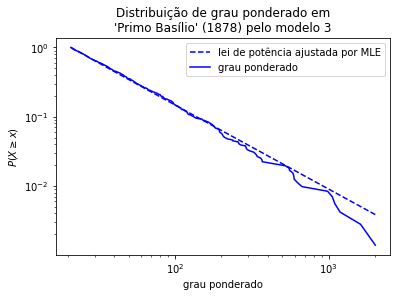

In [ ]:
model_num = 3
filename = f"data/graphs/mod{model_num}/alencar1875.gml"
ig_graph = ig.Graph.Read_GML(filename)

degrees = ig_graph.strength(weights="weight")
fitted = ig.power_law_fit(degrees)
print(fitted)

results = pl.Fit(np.array(degrees) + 1, discrete = True)
results.power_law.plot_ccdf(color='b', linestyle='--', label='lei de potência ajustada por MLE')
results.plot_ccdf(color='b', label='grau ponderado')

plt.title("Distribuição de grau ponderado em\n'Primo Basílio' (1878) pelo modelo " + str(model_num))
plt.xlabel("grau ponderado")
plt.ylabel("$P(X \geq x)$")
plt.legend()

print("")
print('alpha= ', results.power_law.alpha, '  sigma= ', results.power_law.sigma)
print("")